In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import time
import joblib

In [10]:
df = pd.read_csv('./loan_data.csv')

In [11]:
df['person_gender'] = df['person_gender'].map({'male': 0, 'female': 1})

education_mapping = {'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4}
df['person_education'] = df['person_education'].map(education_mapping)

df = df[df['person_home_ownership'] != 'OTHER']

home_ownership_mapping = {'RENT': 0, 'MORTGAGE': 1, 'OWN': 2}
df['person_home_ownership'] = df['person_home_ownership'].map(home_ownership_mapping)

intent_dummies = pd.get_dummies(df['loan_intent'], prefix='loan_intent')
df = pd.concat([df, intent_dummies], axis=1)
df = df.drop('loan_intent', axis=1)

df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map({'No': 0, 'Yes': 1})

numerical_columns = ['loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
for col in numerical_columns:
    df[col].fillna(df[col].median(), inplace=True)

categorical_columns = ['previous_loan_defaults_on_file', 'loan_status']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

X = df.drop('loan_status', axis=1)
y = df['loan_status']

/tmp/ipykernel_1096259/1143381495.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_1096259/1143381495.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [12]:
preprocessed_file_path = './loan_data_preprocessed.csv'
X.to_csv(preprocessed_file_path, index=False)
print(f"Preprocessed data saved to: {preprocessed_file_path}")

Preprocessed data saved to: ./loan_data_preprocessed.csv


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


In [ ]:
print("Training...")
start_time = time.time()

xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.1, 0.05],
    'max_depth': [5, 8, 12],
    'min_samples_split': [2]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")
print(f"Best Parameters: {grid_search.best_params_}")

In [ ]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'fortunate_loan_model_gpu.pkl')
print("Model saved as 'fortunate_loan_model_gpu.pkl'")

Training set size: 31418
Validation set size: 6732
Test set size: 6733
Training XGBoost Classifier with GPU support...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


<ipython-input-8-38b8ef74afcb>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-8-38b8ef74afcb>:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

Training completed in 67.05 seconds.
Best Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 400}
Model saved as 'fortunate_loan_model_gpu.pkl'

Validation Set Results:
Validation Accuracy: 0.9385
Validation F1 Score: 0.8520
Confusion Matrix:
[[5126  112]
 [ 302 1192]]

Test Set Results:
Test Accuracy: 0.9314
Test F1 Score: 0.8343
Confusion Matrix:
[[5108  131]
 [ 331 1163]]
Null Accuracy: 0.7781


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:44:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:44:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


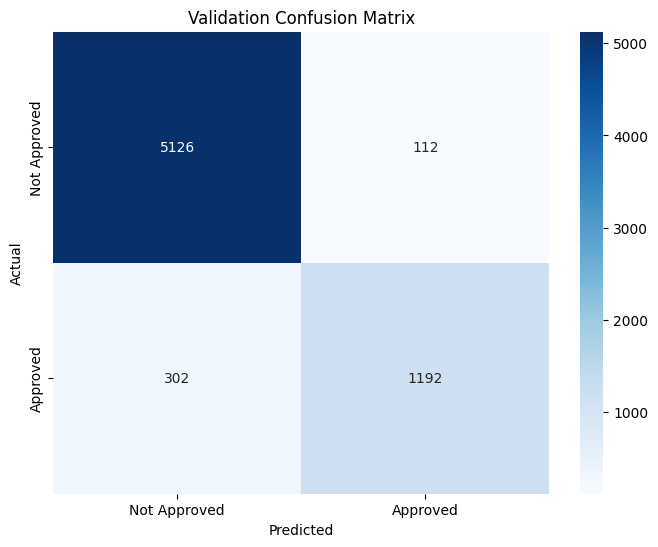

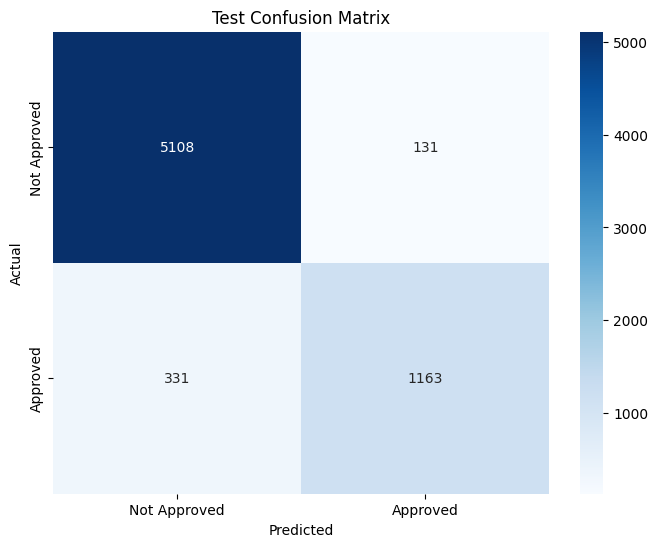

In [ ]:
print("\nValidation Set Results:")
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print("Confusion Matrix:")
print(val_conf_matrix)

print("\nTest Set Results:")
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("Confusion Matrix:")
print(test_conf_matrix)

null_accuracy = max(y_test.value_counts()) / len(y_test)
print(f"Null Accuracy: {null_accuracy:.4f}")

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(val_conf_matrix, labels=["Not Approved", "Approved"], title="Validation Confusion Matrix")
plot_confusion_matrix(test_conf_matrix, labels=["Not Approved", "Approved"], title="Test Confusion Matrix")
